In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pathlib
import numpy as np

In [8]:
DATASET_PATH = 'Images' 
IMG_SIZE = (224, 224) 
BATCH_SIZE = 32
EPOCHS = 10 
VALIDATION_SPLIT = 0.2

In [9]:
data_dir = pathlib.Path(DATASET_PATH)

In [10]:
ds_train = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=VALIDATION_SPLIT,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 20580 files belonging to 120 classes.
Using 16464 files for training.


In [11]:
ds_validation = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 20580 files belonging to 120 classes.
Using 4116 files for validation.


In [12]:
class_names = ds_train.class_names
num_classes = len(class_names)
print(f"Found {num_classes} classes (breeds).")

Found 120 classes (breeds).


In [13]:
def preprocess_data(image, label):
    # MobileNetV2 expects pixel values in the range [-1, 1]
    preprocessed_image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return preprocessed_image, label

Visualizing a batch of training images...


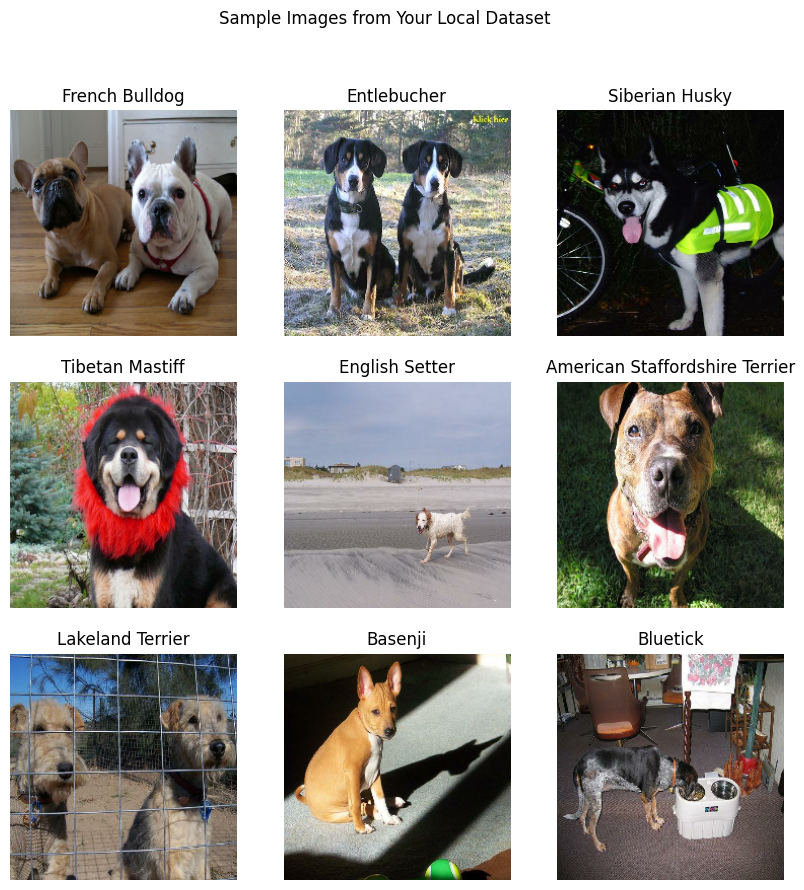

In [14]:
print("Visualizing a batch of training images...")
plt.figure(figsize=(10, 10))
for images, labels in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        # The class names include the original folder ID, we can clean it for display
        display_name = class_names[labels[i]].split('-')[-1].replace('_', ' ').title()
        plt.title(display_name)
        plt.axis("off")
plt.suptitle("Sample Images from Your Local Dataset")
plt.show()


In [15]:
ds_train = ds_train.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
ds_validation = ds_validation.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

In [16]:
AUTOTUNE = tf.data.AUTOTUNE
ds_train = ds_train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
ds_validation = ds_validation.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [18]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False, 
    weights='imagenet'
)

In [19]:
base_model.trainable = False

In [20]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [21]:
print("Compiling the model...")
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Compiling the model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 120)               153720    
                                                                 
Total params: 2,411,704
Trainable params: 153,720
Non-trainable params: 2,257,984
_________________________________________________________________


In [23]:
print(f"\nStarting training for {EPOCHS} epochs...")
history = model.fit(
    ds_train,
    validation_data=ds_validation,
    epochs=EPOCHS
)


Starting training for 10 epochs...
Epoch 1/10
515/515 [==============================] - 59s 75ms/step - loss: 1.1516 - accuracy: 0.7054 - val_loss: 0.5902 - val_accuracy: 0.8190
Epoch 2/10
515/515 [==============================] - 54s 104ms/step - loss: 0.4316 - accuracy: 0.8677 - val_loss: 0.5203 - val_accuracy: 0.8341
Epoch 3/10
515/515 [==============================] - 40s 77ms/step - loss: 0.3100 - accuracy: 0.9029 - val_loss: 0.5200 - val_accuracy: 0.8277
Epoch 4/10
515/515 [==============================] - 37s 73ms/step - loss: 0.2329 - accuracy: 0.9292 - val_loss: 0.5086 - val_accuracy: 0.8353
Epoch 5/10
515/515 [==============================] - 33s 65ms/step - loss: 0.1817 - accuracy: 0.9492 - val_loss: 0.5179 - val_accuracy: 0.8411
Epoch 6/10
515/515 [==============================] - 32s 62ms/step - loss: 0.1528 - accuracy: 0.9569 - val_loss: 0.5392 - val_accuracy: 0.8299
Epoch 7/10
515/515 [==============================] - 31s 60ms/step - loss: 0.1277 - accuracy: 0.96

In [27]:
print("Visualizing training history (Accuracy and Loss)...")
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)
print(f"Accuracy : {acc}")
print(f"Validation Accuracy : {val_acc}")
print(f"Loss : {loss}")
print(f"Validation Loss : {val_loss}")

Visualizing training history (Accuracy and Loss)...
Accuracy : [0.7054178714752197, 0.8676506280899048, 0.902878999710083, 0.9291788339614868, 0.9491618275642395, 0.9569363594055176, 0.9640427827835083, 0.9718780517578125, 0.9758867621421814, 0.9783770442008972]
Validation Accuracy : [0.8189990520477295, 0.8340622186660767, 0.8277453780174255, 0.8352769613265991, 0.8411078453063965, 0.8299319744110107, 0.8386783003807068, 0.8364917635917664, 0.8364917635917664, 0.8360058069229126]
Loss : [1.1516271829605103, 0.4315940737724304, 0.30998653173446655, 0.23287591338157654, 0.1817164272069931, 0.15278784930706024, 0.127722829580307, 0.10632598400115967, 0.09399039298295975, 0.0847550556063652]
Validation Loss : [0.5902185440063477, 0.5202597379684448, 0.5199629068374634, 0.5085929036140442, 0.517913818359375, 0.5392439365386963, 0.5282840132713318, 0.5445818901062012, 0.5490522980690002, 0.5627039670944214]


Text(0.5, 1.0, 'Training and Validation Accuracy')

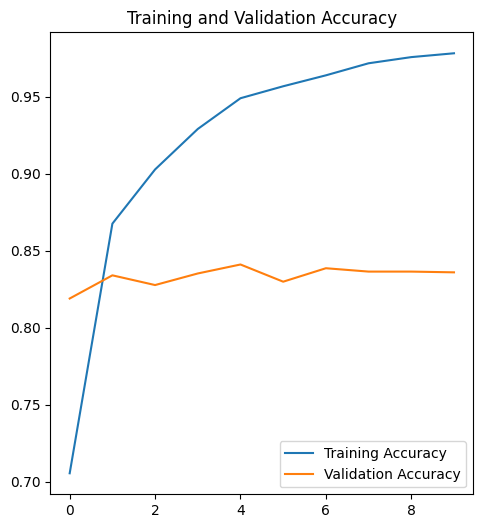

In [25]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

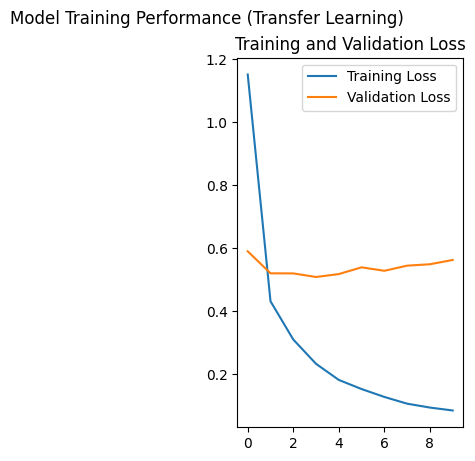

In [26]:
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.suptitle("Model Training Performance (Transfer Learning)")
plt.show()
